# BAL pseudobulk analysis, pt. 4

In [1]:
import collections
import itertools
import functools
import json
import math
import os
import re
import sys
import pathlib
import datetime
import hashlib

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy
import statsmodels.stats.multitest
import decoupler
import requests

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/scvi_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.insert(0, "../lib/")

In [3]:
import sc_utils

In [4]:
FONT_DIR = '/projects/b1038/Pulmonary/nmarkov/fonts'
for f in os.listdir(FONT_DIR):
    if f.endswith('.ttf'):
        mpl.font_manager.fontManager.addfont(f'{FONT_DIR}/{f}')

In [5]:
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["pdf.fonttype"] = 42
# plt.rcParams['figure.constrained_layout.use'] = False
# mpl.rcParams['mathtext.default'] = 'regular'

In [6]:
%config InlineBackend.figure_format = "retina"

In [7]:
DATA = pathlib.Path('../../data/31_bal-object/')

In [8]:
ds_processed = sc.read_h5ad(DATA / '03_bal-object/03_bal-object.h5ad')

In [9]:
DATA_DIR = DATA / 'pseudobulk-gsva'

In [10]:
DEG_DIR = DATA / '15_pseudobulk-mmf'

In [11]:
def get_color_annotations(df, mapping):
    result = []
    for column, palette in mapping.items():
        values = df[column].unique()
        if pd.api.types.is_categorical_dtype(df[column]):
            values = df[column].cat.categories
        lut = dict(zip(values, sns.color_palette(palette, n_colors=values.size).as_hex()))
        result.append(df[column].map(lut))
    return pd.concat(result, axis=1)

In [12]:
def get_cell_type_from_slug(slug: str, ds: sc.AnnData) -> str:
    for cell_type in ds.obs.cell_type.unique():
        cell_type_slug = cell_type.replace(" ", "_").replace("/", "_")
        if slug == cell_type_slug:
            return cell_type
    raise ValueError(f"Cannot find cluster for {slug}")

In [ ]:
MODEL = 'degs'

def load_cell_type_info(folder, data_folder):
    name = folder.name
    degs = pd.read_csv(folder / MODEL / 'degs.csv', index_col=0)
    degs_filt = pd.read_csv(folder / MODEL / 'degs-filt.csv', index_col=0)
    expr = pd.read_table(data_folder / 'data' / f'{name}.txt', index_col=0)
    gene_cells = pd.read_table(data_folder / 'data' / f'{name}-n_cells.txt', index_col=0)
    meta = pd.read_csv(folder / 'meta.csv', index_col=0)

    go_ctrl = folder / MODEL / 'go-control.csv'
    if go_ctrl.exists():
        go_ctrl = pd.read_csv(go_ctrl, index_col=0)
    else:
        go_ctrl = None

    go_ssc = folder / MODEL / 'go-ssc.csv'
    if go_ssc.exists():
        go_ssc = pd.read_csv(go_ssc, index_col=0)
    else:
        go_ssc = None

    # ensure we operate on filtered samples
    gene_cells = gene_cells.loc[:, meta["External Sample ID"]]
    gene_cells = gene_cells.loc[gene_cells.sum(axis=1) > 0, :]

    return {
        'degs': degs,
        'filtered_degs': degs_filt,
        'meta': meta,
        'gene_cells': gene_cells,
        'expr': expr,
        'go_control': go_ctrl,
        'go_ssc': go_ssc,
    }


def process_cell_type(folder, data_folder):
    info = {}

    clust = get_cell_type_from_slug(folder.name, ds_processed)
    info.update(load_cell_type_info(folder, data_folder))

    return info

In [37]:
data = {}

for folder in sorted(DEG_DIR.iterdir()):
    if not folder.is_dir():
        continue
    if not (folder / MODEL).exists():
        continue
    if folder.name == 'global':
        continue
    data[folder.name] = process_cell_type(folder, DATA_DIR / folder.name)

In [38]:
data = {
    k.replace('_', ' ')\
        .replace('MoAM-3', 'MoAM-2')\
        .replace('MoAM-4', 'MoAM-3')\
        .replace('Perivascular', 'Interstitial'): v
    for k, v in data.items()
}

In [16]:
msigdb = decoupler.get_resource('MSigDB', organism='human')

In [17]:
hallmark = msigdb[msigdb.collection.eq('hallmark')]

In [18]:
hallmark = hallmark[~hallmark.duplicated(['geneset', 'genesymbol'])]

In [19]:
for k, v in data.items():
    print(k, v['filtered_degs'].shape[0])

B cells 834
CCR7+ DC 643
CD4 TEM cells 1672
CD4 naive T cells 771
CD8 TEM cells 326
CD8 TRM cells 1063
DC1 1910
DC2 3164
MoAM-1 4138
MoAM-2 7718
MoAM-3 profibrotic 5534
Monocytes 4159
Interstitial macrophages 4477
Proliferating macrophages 7281
TRAM-1 9473
TRAM-2 8759
TRAM-3 7902
TRAM-4 6345
TRAM-5 MT1G 5214
TRAM-6 activated 6729
Tregs 281


# 1. GSEA results on the filtered DEGs

In [39]:
result = []
GSEA_PATH = DATA / '15d_degs_mmf_gsea'
for k, ct_info in data.items():
    # Threshold GSEA analysis to at least 1000 genes in comparison
    if ct_info['filtered_degs'].shape[0] < 1000:
        continue
    ct_path = GSEA_PATH / k
    os.makedirs(ct_path, exist_ok=True)
    ct_info['filtered_degs'].to_csv(GSEA_PATH / k / 'degs.csv')
    if not (ct_path / 'gsea.csv').exists():
        print(f'Cell type {k} GSEA results missing, run snakemake')
    else:
        enriched = pd.read_csv(ct_path / 'gsea.csv', index_col=0)
        enriched['cell_type'] = k
        enriched['n_genes'] = len(ct_info['filtered_degs'])
        enriched['n_degs'] = ct_info['filtered_degs'].padj.lt(0.05).sum()
        result.append(enriched)

In [41]:
data['MoAM-2'] = data['MoAM-2 mature']
del data['MoAM-2 mature']

In [42]:
result = pd.concat(result)

In [46]:
result.cell_type = result.cell_type.replace({'MoAM-2 mature': 'MoAM-2'})

Remove Harmonizome pathway: not interested anymore

In [47]:
result = result.loc[result.Term.ne('Harmonizome_PF')].copy()

Remove Purine metabolism pathway: display separately later

In [48]:
result = result.loc[result.Term.ne('Purine metabolism')].copy()

Remove exactly `0` p-values (improbable), set them to minimum p-value times `0.01`.

In [49]:
result['p-value'] = result['NOM p-value'].copy()
idx = result['p-value'].eq(0)
min_p_val = result['p-value'][~idx].min()
result.loc[idx, 'p-value'] = min_p_val * 0.01

In [50]:
print(f'P-values exactly 0: {idx.sum()}')

P-values exactly 0: 0


In [51]:
result['padj'] = statsmodels.stats.multitest.fdrcorrection(result['p-value'])[1]

In [52]:
result.to_csv('15e_degs_mmf_gsea.csv')

In [53]:
result.to_csv('00_figures/Table_S8_myco_vs_not_gsea.csv', index=False)

In [54]:
result['-log10(padj)'] = -np.log10(result.padj)

In [55]:
result['-log10(padj)'] *= np.sign(result.NES)

In [56]:
result_df = result.pivot_table(
    index='cell_type',
    columns='Term',
    values='-log10(padj)'
)

In [57]:
result_df_plot = result_df.fillna(0).T

In [58]:
rownames = result_df.columns.str.replace('HALLMARK_', '')

In [59]:
stars = np.empty_like(result_df_plot, dtype=str)
stars[result_df_plot.abs().gt(-np.log10(0.05))] = '*'

In [60]:
def process_hallmark_name(name):
    short_words = ('ACID', 'VIA', 'BETA', 'LATE', 'BILE', 'HEME')
    result = []
    words = name.split('_')
    for word in words:
        if re.search(r'\d', word) or len(word) < 5 and word not in short_words:
            result.append(word)
        else:
            result.append(word.lower())
    result = ' '.join(result)
    result = result[0].capitalize() + result[1:]
    return result

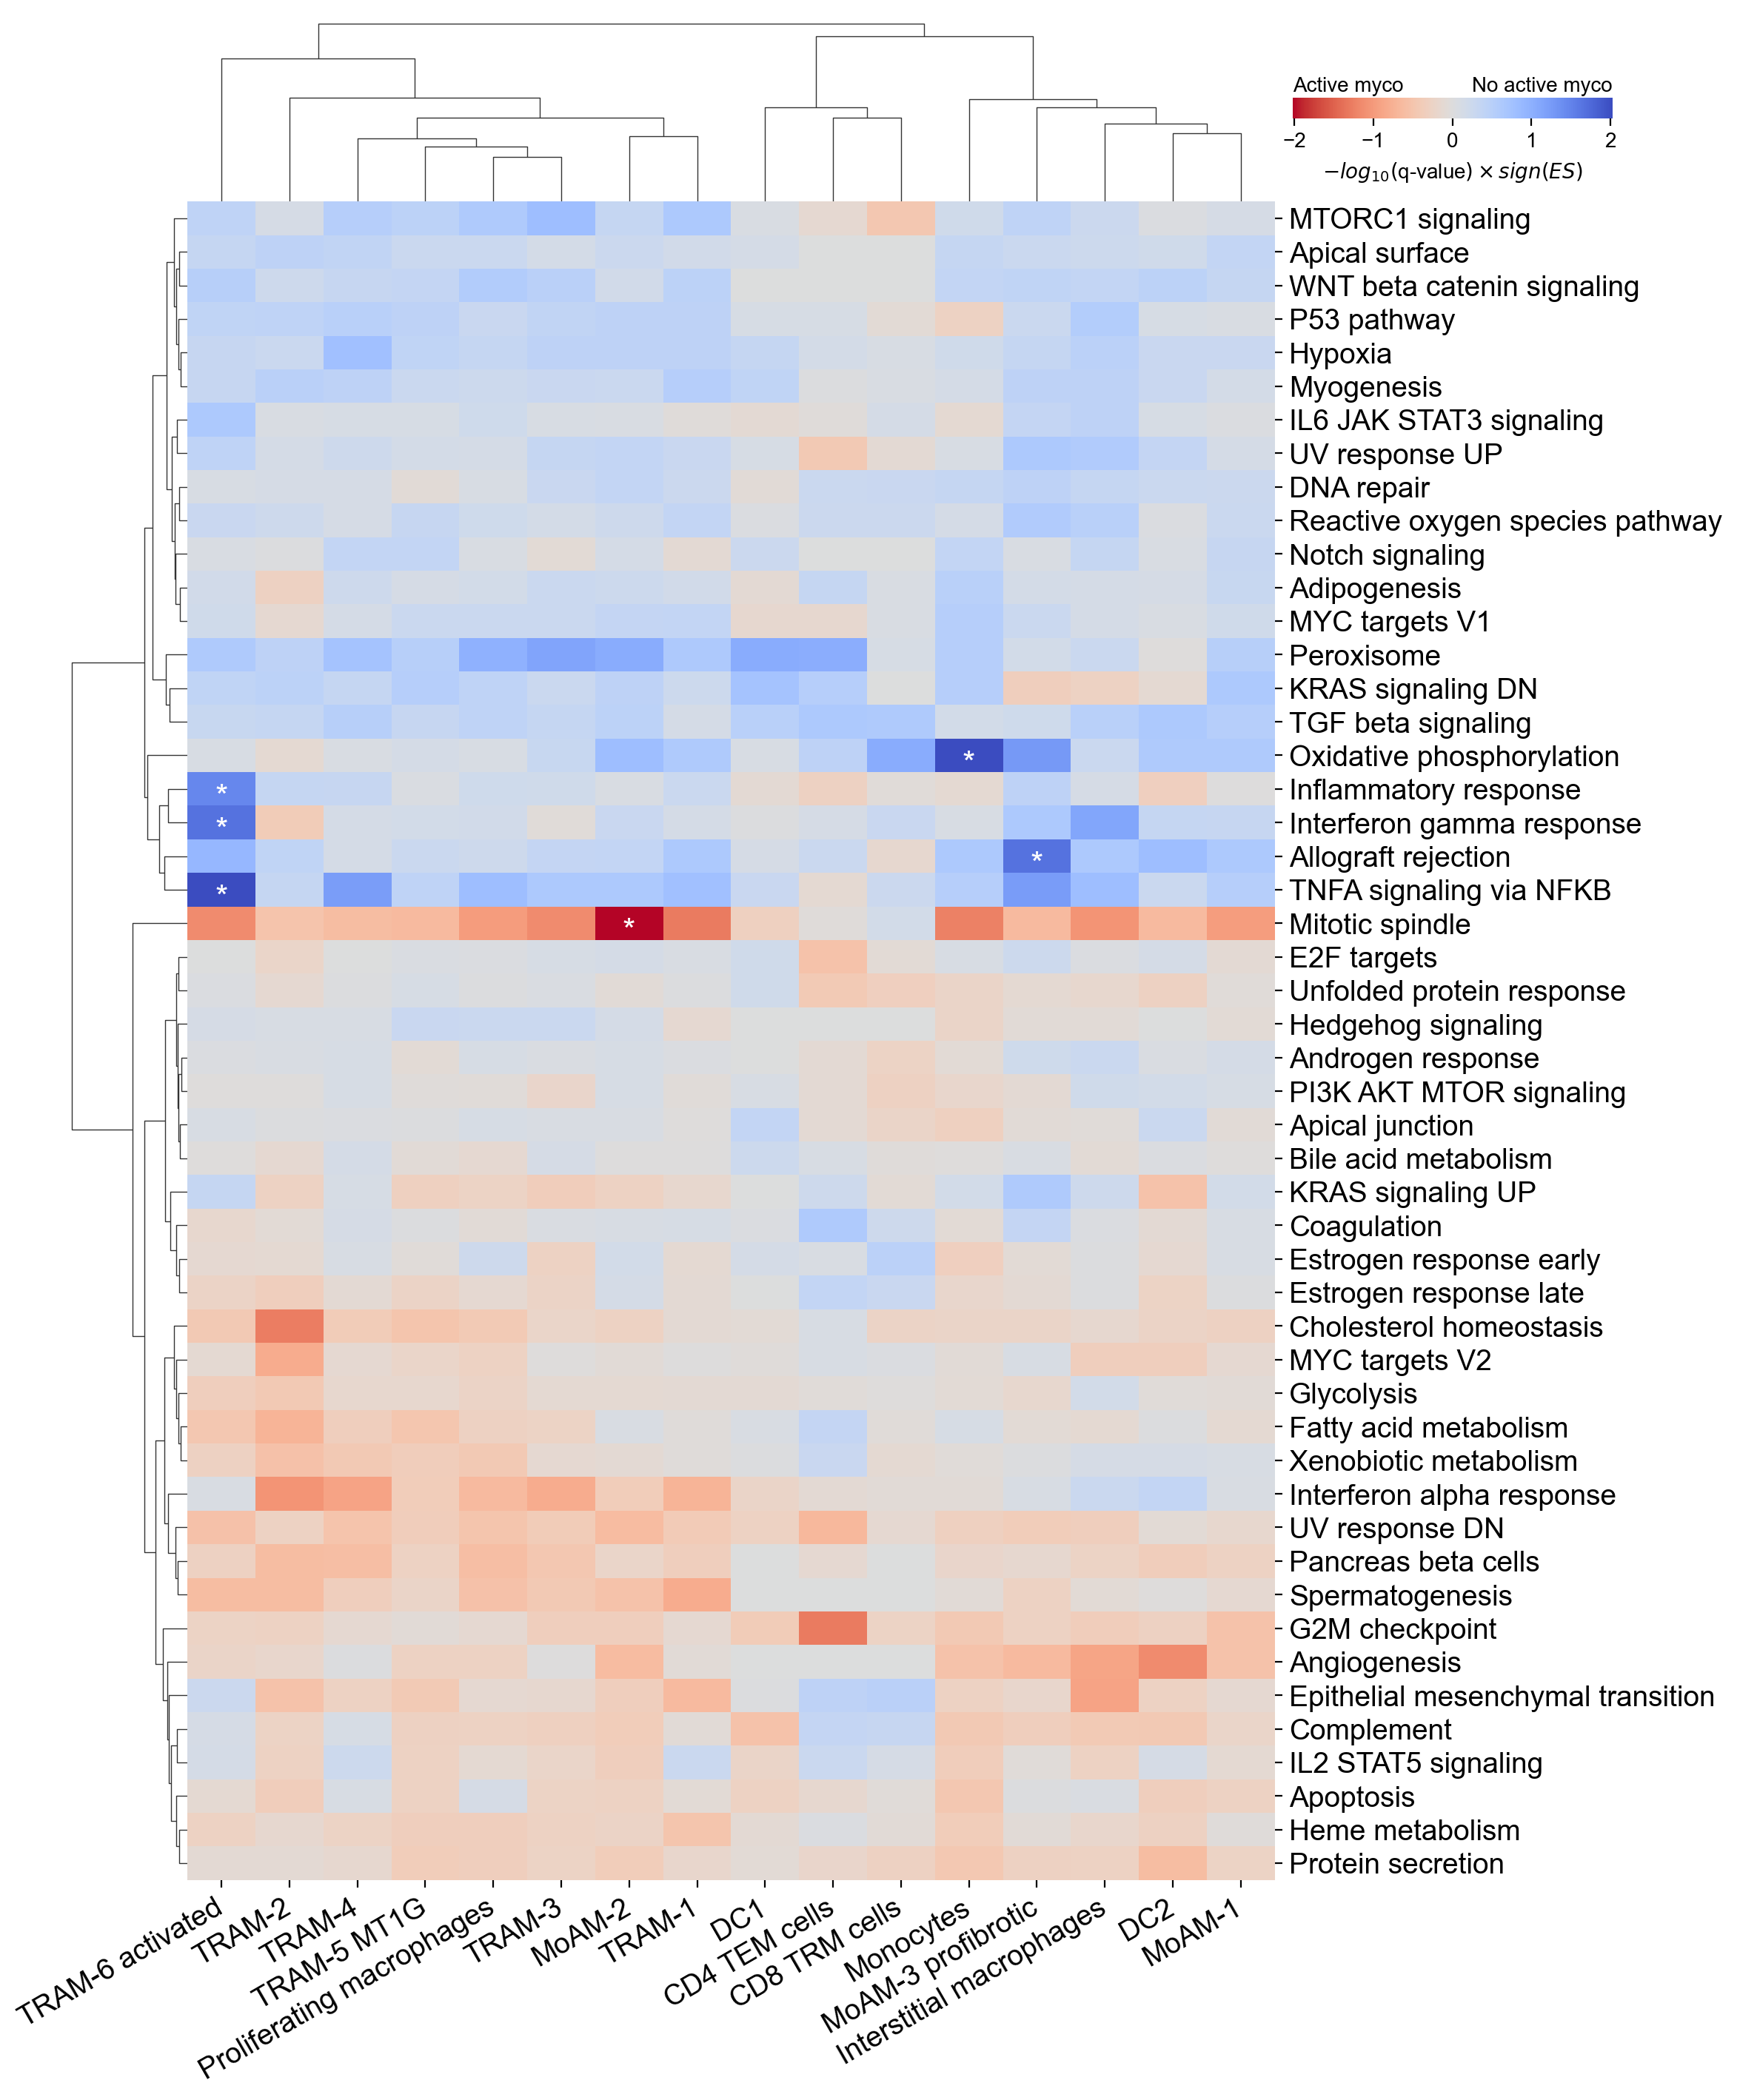

In [67]:
cg = sns.clustermap(
    result_df_plot,
    method='ward',
    figsize=(12, 14),
    dendrogram_ratio=0.1,
    cbar_pos=(0.8, 0.82, 0.1, 0.02),
    cbar_kws=dict(
        label='$-log_{10}($q-value$) \\times sign(ES)$',
        orientation='horizontal'
    ),
    xticklabels=result_df.index,
    yticklabels=[process_hallmark_name(x) for x in rownames],
    cmap='coolwarm_r',
    annot=stars,
    fmt='',
    annot_kws=dict(
        va='center_baseline',
        fontsize=16
    )
)
cg.ax_cbar.annotate('Active myco', (0, 1.3), xycoords='axes fraction', ha='left')
cg.ax_cbar.annotate('No active myco', (1, 1.3), xycoords='axes fraction', ha='right')

cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_heatmap.set_xlabel('')
cg.ax_heatmap.set_ylabel('')

cg.ax_heatmap.set_xticklabels(
    cg.ax_heatmap.get_xticklabels(),
    fontsize=14,
    rotation=30,
    ha='right'
)
trans = mpl.transforms.Affine2D().translate(8, 0)
for t in cg.ax_heatmap.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

cg.ax_heatmap.set_yticklabels(
    cg.ax_heatmap.get_yticklabels(),
    fontsize=14,
)

for t in cg.ax_heatmap.texts:
    if t.get_text() == '*':
        p = t.get_position()
        t.set_position((p[0], p[1] + 0.2))

cg.ax_col_dendrogram.figure.subplots_adjust(left=0.05, bottom=0.1, top=1, right=0.73)
cg.ax_cbar.set_position((0.74, 0.95, 0.18, 0.01))

# cg.ax_col_dendrogram.figure.savefig('00_figures/Figure_3A_gsea.pdf', dpi=300)

In [68]:
ct_clusters = pd.DataFrame({
    'cluster': scipy.cluster.hierarchy.cut_tree(cg.dendrogram_col.linkage, n_clusters=3).reshape(-1),
}, index=result_df_plot.columns)

In [69]:
col_colors = get_color_annotations(ct_clusters, {
    'cluster': 'Set2'
})

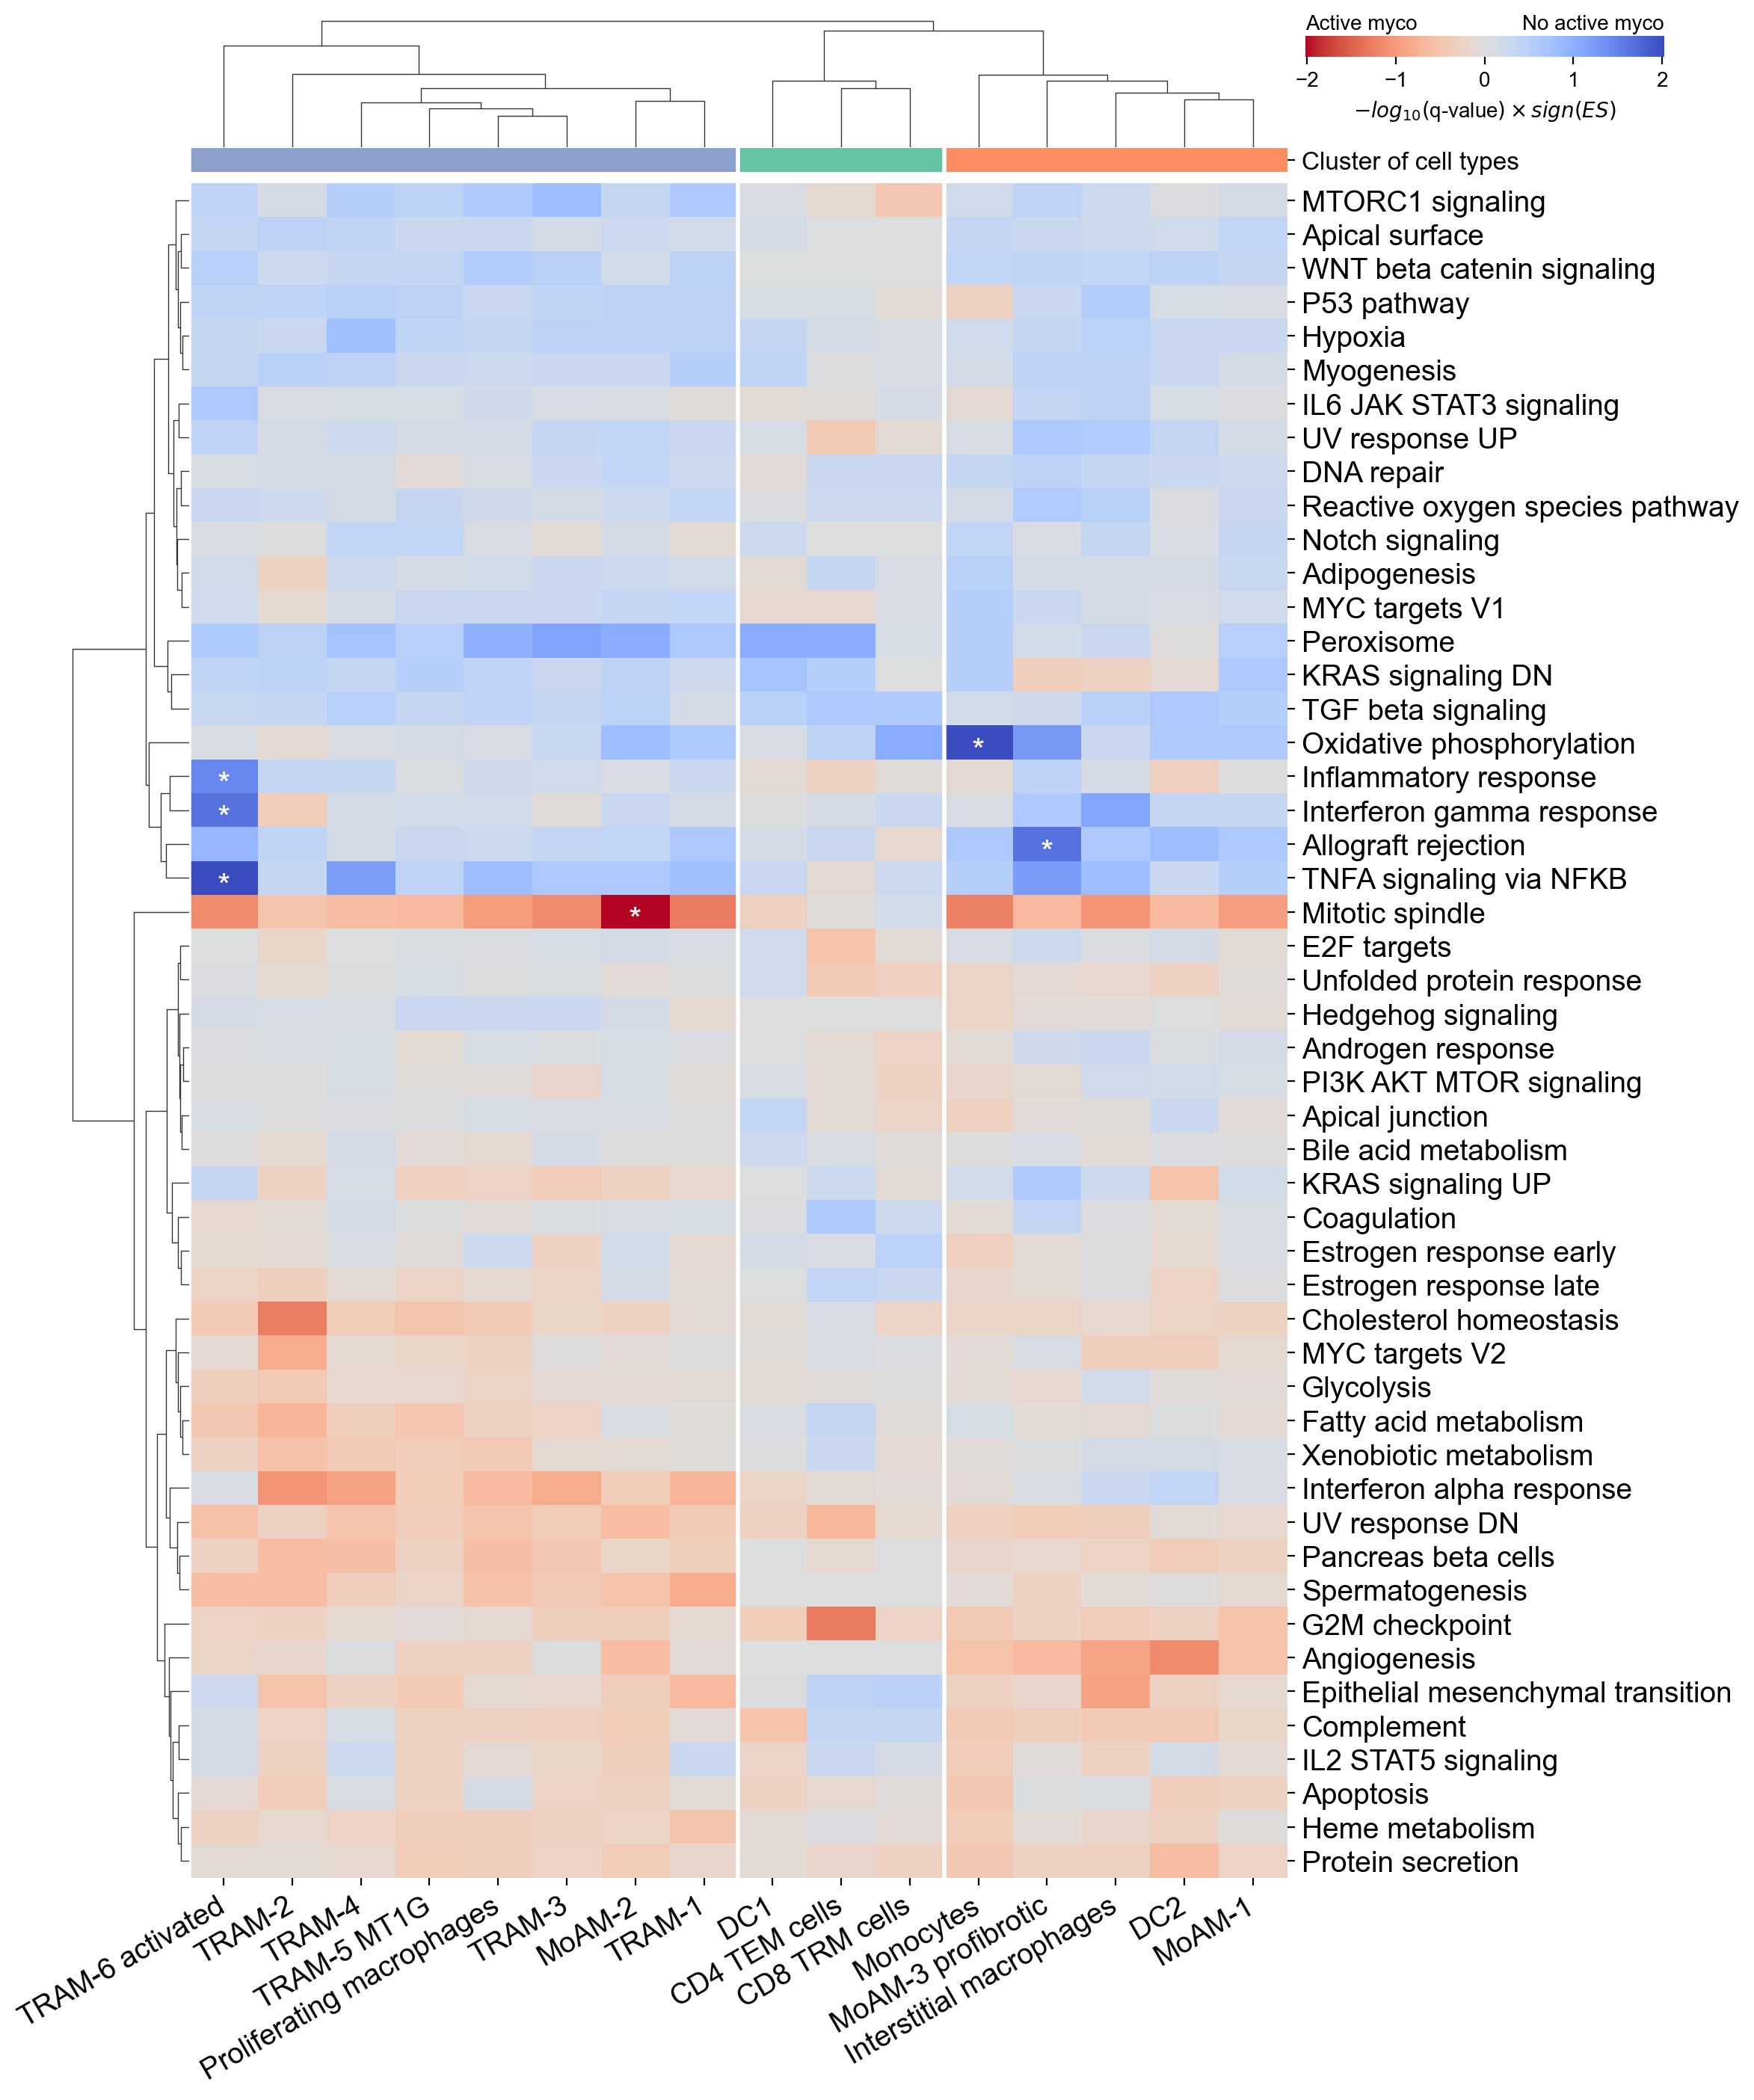

In [76]:
cg = sns.clustermap(
    result_df_plot,
    method='ward',
    figsize=(12, 14),
    dendrogram_ratio=(0.1, 0.06),
    cbar_pos=(0.78, 0.82, 0.1, 0.02),
    cbar_kws=dict(
        label='$-log_{10}($q-value$) \\times sign(ES)$',
        orientation='horizontal'
    ),
    xticklabels=result_df.index,
    yticklabels=[process_hallmark_name(x) for x in rownames],
    cmap='coolwarm_r',
    annot=stars,
    fmt='',
    annot_kws=dict(
        va='center_baseline',
        fontsize=16
    ),
    col_colors=col_colors
)
cg.ax_cbar.annotate('Active myco', (0, 1.3), xycoords='axes fraction', ha='left')
cg.ax_cbar.annotate('No active myco', (1, 1.3), xycoords='axes fraction', ha='right')

cg.ax_heatmap.collections[0].set_rasterized(True)
cg.ax_heatmap.set_xlabel('')
cg.ax_heatmap.set_ylabel('')

cg.ax_heatmap.set_xticklabels(
    cg.ax_heatmap.get_xticklabels(),
    fontsize=14,
    rotation=30,
    ha='right'
)
trans = mpl.transforms.Affine2D().translate(8, 0)
for t in cg.ax_heatmap.get_xticklabels():
    t.set_transform(t.get_transform() + trans)

cg.ax_heatmap.set_yticklabels(
    cg.ax_heatmap.get_yticklabels(),
    fontsize=14,
)

cg.ax_col_colors.set_yticks([0.5], labels=['Cluster of cell types'], size=12)

for t in cg.ax_heatmap.texts:
    if t.get_text() == '*':
        p = t.get_position()
        t.set_position((p[0], p[1] + 0.2))

cg.ax_col_dendrogram.figure.subplots_adjust(left=0.05, bottom=0.1, top=0.99, right=0.73)

p = cg.ax_col_colors.get_position()
p.y0 += 0.005
p.y1 -= 0.01
cg.ax_col_colors.set_position(p)

p = cg.ax_col_dendrogram.get_position()
p.y0 -= 0.01
cg.ax_col_dendrogram.set_position(p)

for i, _ in col_colors.cluster.iloc[
    cg.dendrogram_col.reordered_ind
].reset_index(drop=True).drop_duplicates().items():
    cg.ax_col_colors.axvline(i, lw=2, c='w')
    cg.ax_heatmap.axvline(i, lw=2, c='w')

cg.ax_cbar.set_position((0.74, 0.97, 0.2, 0.01))

cg.ax_col_dendrogram.figure.savefig('00_figures/Figure_3A_gsea.pdf', dpi=300)

## Save for Morpheus

In [65]:
GENERATOR = 'Nick'

In [66]:
GSEA_DIR = pathlib.Path('15e_mmf_gsea')

In [67]:
os.makedirs(GSEA_DIR, exist_ok=True)

In [68]:
result_df_morpheus = result_df_plot.copy()
result_df_morpheus.index = result_df_morpheus.index.str.replace('HALLMARK_', '')
result_df_morpheus.to_csv(GSEA_DIR / 'gsea.tsv', sep='\t')

In [69]:
HTML = """
<!DOCTYPE html>
<html>
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1.0"/>
    <meta http-equiv="content-type" content="text/html; charset=utf8"/>
    <title>Pathogen comparisons GSEA</title>
    <style type="text/css">
        html {
          margin: 0; padding: 0;
          font-size: 20px; font-family: Helvetica, Verdana, sans-serif;
        }
        body {margin: 0; padding: 10px 10px;}
        a {color: #1385cb}
        a:visited {color: #0e74bc}
        .header {margin-bottom: 10px;}
        .header h2, .header h3 {font-weight: normal; text-align: center; margin: 0 0 6px 0;}
        #morpheus-container {
            width: auto;
            height: auto;
            min-width: 1200px;
            min-height: 800px;
            visibility: hidden;
        }
      </style>
    <link rel="stylesheet" href="https://software.broadinstitute.org/morpheus/css/morpheus-latest.min.css">
    <script>if (typeof module === 'object') {
    window.module = module;
    module = undefined;

    }</script>

    <script type="text/javascript" src="https://software.broadinstitute.org/morpheus/js/morpheus-external-latest.min.js"></script>
    <script src="https://software.broadinstitute.org/morpheus/js/morpheus-latest.min.js"></script>
</head>
<body>
    <div class="header">
        <h2>GSEA on Myco vs Naive 10x 3' V3 comparisons (significant is >1.3)</h2>
        Generated by %s on %s<br/><br/>
        <b>Red is MMF, Blue is Naive</b>
    </div>
    <div id="morpheus-container"></div>

    <script type="text/javascript">
        window.heatmap = new morpheus.HeatMap({
            el: document.querySelector('#morpheus-container'),
            name: "GSEA on v3 DEGs",
            dataset: "gsea.tsv",
            rows: [
                {field: "id", display: ["text"]}
            ],
            columns: [
                {field: "id", display: ["color", "text"]}
            ],
            columnColorModel: {
            },
            rowColorModel: {
            },
            colorScheme: { // optional color scheme. default is relative
                type: 'fixed',
                map: [{
                    value: -5,
                    color: '#ff0000'
                }, {
                    value: 0,
                    color: '#ffffff'
                }, {
                    value: 5,
                    color: '#0000ff'
                }],
                conditions: [
                    {inheritColor: false, shape: 'diamond', v1: 1.30103, v1Op: 'gt', color: 'black'},
                    {inheritColor: false, shape: 'diamond', v2: -1.30103, v2Op: 'lt', color: 'black'}
                ]
            },
            tools: [{ name: "Hierarchical Clustering", params: {cluster: "Rows"} }]
        });
        window.onload = function() {
            window.setTimeout(function() {
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                window.heatmap.fitToWindow({fitRows: true, fitColumns: true, repaint: true});
                document.getElementById('morpheus-container').style.visibility = 'visible';
            }, 200)
        }
    </script>
</body>
</html>
"""

In [70]:
html = HTML % (
    GENERATOR,
    datetime.datetime.now().strftime('%d %b %Y, %I:%M%p')
)

In [71]:
with open(GSEA_DIR / 'index.html', 'w') as out:
    out.write(html)

## KEGG pathways for Myco

Mycophenolic acid inhibits IMPDH (inosine-5'-monophosphate dehydrogenase), which converts inosine-5'-monophosphate (IMP) to xanthosine-5'-phospate (XMP), to be converted to GMP (guanosine monophosphate). See https://www.kegg.jp/pathway/map00230

In [77]:
keggdb = decoupler.get_resource('KEGG-PC', organism='human')

124kB [00:00, 205MB/s]


In [78]:
purine_pathway = keggdb.loc[keggdb.pathway.str.contains('Purine')]

In [79]:
result = []
for k, ct_info in data.items():
    degs = ct_info['filtered_degs']
    degs = degs.loc[degs.padj.lt(0.05)]
    n_purine_degs = degs.index.isin(purine_pathway.genesymbol).sum()
    if n_purine_degs == 0:
        print(f'No GO enrichment for {k}: no DEGs from Purine metabolism')
    res = decoupler.get_ora_df(
        degs,
        purine_pathway,
        source='pathway',
        target='genesymbol'
    )
    res['cell_type'] = k
    result.append(res)
result = pd.concat(result)

No GO enrichment for B cells: no DEGs from Purine metabolism
No GO enrichment for CCR7+ DC: no DEGs from Purine metabolism
No GO enrichment for CD4 TEM cells: no DEGs from Purine metabolism
No GO enrichment for CD4 naive T cells: no DEGs from Purine metabolism
No GO enrichment for CD8 TEM cells: no DEGs from Purine metabolism
No GO enrichment for CD8 TRM cells: no DEGs from Purine metabolism
No GO enrichment for DC1: no DEGs from Purine metabolism
No GO enrichment for DC2: no DEGs from Purine metabolism
No GO enrichment for TRAM-1: no DEGs from Purine metabolism
No GO enrichment for TRAM-2: no DEGs from Purine metabolism
No GO enrichment for TRAM-3: no DEGs from Purine metabolism
No GO enrichment for Tregs: no DEGs from Purine metabolism


In [80]:
result

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features,cell_type
0,Purine metabolism,54,0.018519,0.702974,0.702974,1.237849,0.436263,PNP,MoAM-1
0,Purine metabolism,54,0.074074,0.013983,0.013983,4.822720,20.592528,DCK;PAPSS2;PNP;PRPS2,MoAM-3 profibrotic
0,Purine metabolism,54,0.055556,0.109410,0.109410,3.003442,6.645581,DCK;PAPSS2;PNP,Monocytes
0,Purine metabolism,54,0.018519,0.525698,0.525698,2.007262,1.290728,PNP,Interstitial macrophages
0,Purine metabolism,54,0.018519,0.706241,0.706241,1.226785,0.426674,PRPS2,Proliferating macrophages
0,Purine metabolism,54,0.018519,0.631638,0.631638,1.502014,0.690083,PNP,TRAM-4
0,Purine metabolism,54,0.018519,0.641647,0.641647,1.462014,0.648720,PNPT1,TRAM-5 MT1G
0,Purine metabolism,54,0.074074,0.041461,0.041461,3.427594,10.910029,DCK;PAPSS2;PNP;PNPT1,TRAM-6 activated
0,Purine metabolism,54,0.074074,0.044138,0.044138,3.357714,10.477529,DCK;PAPSS2;PNP;PRPS2,MoAM-2


In [81]:
CT_ORDER = [
    'Monocytes',
    'MoAM-1',
    'MoAM-2',
    'MoAM-3 profibrotic',

    'TRAM-4',
    'TRAM-5 MT1G',
    'TRAM-6 activated',

    'Interstitial macrophages',
    'Proliferating macrophages'
]
result.cell_type = pd.Categorical(result.cell_type, categories=CT_ORDER)
result.sort_values('cell_type', inplace=True, ascending=False)

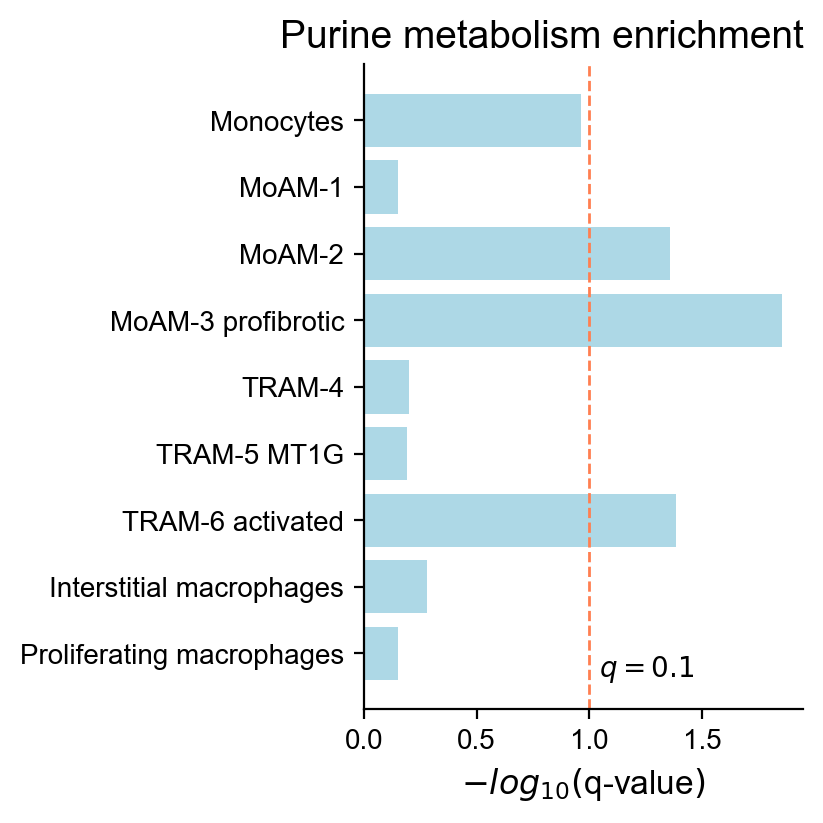

In [87]:
fig, ax = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax.barh(
    range(result.shape[0]),
    -np.log10(result['FDR p-value']),
    color='lightblue'
)
ax.axvline(x=-np.log10(0.1), c='coral', ls='--', lw=1)
ax.annotate(
    '$q=0.1$',
    (-np.log10(0.1), 0),
    xytext=(10, 0),
    textcoords='offset pixels',
    va='top'
)
ax.set_yticks(list(range(result.shape[0])))
ax.set_yticklabels(reversed(result.cell_type.cat.categories))
ax.set_xlabel('$-log_{10}($q-value$)$', size=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Purine metabolism enrichment', size=14, loc='right')
fig.savefig('00_figures/Figure_3B_purine_met_enr.pdf')